# Twitter Job Hunter

In [24]:
!pip install textstat

In [25]:
!pip install lexicalrichness

In [26]:
# Import the required libraries
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings

from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')

import plotly.express as px # Importing plotly express to load dataset

import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(2018)

nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from wordcloud import WordCloud,STOPWORDS

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
sp = spacy.load('en_core_web_sm')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
# Loading the dataset.
#
twitter_df = pd.read_csv("twitter-job-hunter-chatbot.csv", encoding = 'unicode_escape')


In [28]:
# Check the top 5 rows of the dataset.
#
twitter_df.head()

,Datetime,Text,Source,harsh tag,Favourite Count,Retweets,6,7,submitter_name
0,18/07/2020 11:46,"b""Ladies!!! #IkoKaziKE #IkoKazi Today, I reall...",b'Mimimkenya7',"['IkoKaziKE', 'IkoKazi']",NaN,775.0,NaN,NaN,Brian Cheye
1,18/07/2020 11:18,b'#IkoKaziKe #IkoKazi Looking for a Audit Trai...,b'MtandaoPromoter',"['IkoKaziKe', 'IkoKazi']",NaN,5.0,NaN,NaN,Brian Cheye
2,18/07/2020 09:08,b'@moneychapKE are an online crowdfunding and ...,b'KameneAndJalas',"['KameneAndJalas', 'ikoJob', 'TwendeKaziKe', '...",NaN,15675.0,NaN,NaN,Brian Cheye
3,18/07/2020 09:07,b'We are an online crowdfunding and fundraisin...,b'moneychapKE',"['IkoKazi', 'IkoKaziKE']",NaN,79.0,NaN,NaN,Brian Cheye
4,18/07/2020 08:46,b'Striding into the weekend with a productive ...,b'amunsoft',"['webdeveloper', 'business', 'IkoKazi', 'IkoKa...",NaN,2.0,NaN,NaN,Brian Cheye


In [29]:
# Check the bottom 5 rows of the dataset.
#
twitter_df.tail()

,Datetime,Text,Source,harsh tag,Favourite Count,Retweets,6,7,submitter_name
29669,27/06/2020 05:03,World Of Legal Research Blog Writing Competiti...,Simon Ingari,0,0.0,NaN,NaN,NaN,Kennedy Njoroge
29670,27/06/2020 03:32,JTL Hiring Drivers - https://opportunitiesfor...,Simon Ingari,0,1.0,NaN,NaN,NaN,Kennedy Njoroge
29671,27/06/2020 00:25,DÃ¼nya mirasÄ± Aizanoi'de binlerce yÄ±l sonra ...,HaberVer.me,0,0.0,NaN,NaN,NaN,Kennedy Njoroge
29672,27/06/2020 00:24,Happy Sabbath! \n\nDo you require Graphic Desi...,Mtaa Designs,0,1.0,NaN,NaN,NaN,Kennedy Njoroge
29673,27/06/2020 00:09,Searching for A NEW JOB? Start with a competit...,Apprentice Kenya,0,1.0,NaN,NaN,NaN,Kennedy Njoroge


In [30]:
# check for the datatypes.
#
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29674 entries, 0 to 29673
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Datetime         29674 non-null  object 
 1   Text             29674 non-null  object 
 2   Source           29460 non-null  object 
 3   harsh tag        4721 non-null   object 
 4   Favourite Count  29142 non-null  float64
 5   Retweets         27122 non-null  float64
 6   6                23075 non-null  float64
 7   7                23075 non-null  float64
 8   submitter_name   29674 non-null  object 
dtypes: float64(4), object(5)
memory usage: 2.0+ MB


In [31]:
# check for any null values
twitter_df.isnull().values.any()

True

In [32]:
# Check for null values in the text column
#
twitter_df["Text"].isnull().values.any()

False

**Drop Null Values**

In [33]:
# Only consider the tweets that the source is not null.
#
twitter_df = twitter_df[~twitter_df["Source"].isnull()]
twitter_df["Source"].isnull().values.any()

False

In [34]:
# derive a new dataframe having the fields that we require.
#
twitter_df = twitter_df[["Text","Source"]]
twitter_df.sample(5)

,Text,Source
26354,9 Skills Most Proffered By Employers In Kenya ...,"Nairobi, Kenya"
3544,A white-supremacy-denier just accused me of ra...,Twitter for iPhone
19765,#Nowhiring an ETL/SQL Developer in (#AustinTX)...,AlliedConsults
14373,The @UniGroningenFEB is looking for a PhD cand...,AlettaJacobsSPH
25724,As Kenya resumed domestic flights yesterday it...,Nairobi



**Some cleaning requirements**
>>
Get rid of punctuations, numbers and even special characters
stop words
tokenization
stemming

**Custom Functions**

In [46]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def cleaning(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
    def pad_number(pattern):
        matched_string = pattern.group(0)
        return pad_str(matched_string)
    text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    def pad_pattern(pattern):
       matched_string = pattern.group(0)
       return pad_str(matched_string)
    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # kenyan shillings
    
    text = re.sub("(?<=[0-9])ks ", " ks ", text, flags=re.IGNORECASE)
    text = re.sub(" ks(?=[0-9])", " ks ", text, flags=re.IGNORECASE)
    
    # clean text rules 
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE)
    text = re.sub(r" ds ", " data science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" nlp ", " Natural Language Processing ", text, flags=re.IGNORECASE)
    text = re.sub(r" phd ", " Doctor of Philosophy", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [47]:
twitter_df['clean_tweet'] = twitter_df['Text'].apply(cleaning)
twitter_df.head()

,Text,Source,clean_tweet
0,"b""Ladies!!! #IkoKaziKE #IkoKazi Today, I reall...",b'Mimimkenya7',bladies ikokazike ikokazi today i ...
1,b'#IkoKaziKe #IkoKazi Looking for a Audit Trai...,b'MtandaoPromoter',b ikokazike ikokazi looking for a audit tra...
2,b'@moneychapKE are an online crowdfunding and ...,b'KameneAndJalas',b moneychapke are an online crowdfunding and ...
3,b'We are an online crowdfunding and fundraisin...,b'moneychapKE',bwe are an online crowdfunding and fundraising...
4,b'Striding into the weekend with a productive ...,b'amunsoft',bstriding into the weekend with a productive f...


**Function for creating a word cloud**

In [48]:
# Create a word cloud
#
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

**Function for Collecting Hashtags**

In [49]:
# function to collect hashtags.
#
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

**Some Questions**
>>
1. Common words in the entire dataset
>>
2. Frequency of Source
>>
3. Common words by Source
>> 
4. How many hash tags are there in a tweet
>>
5. What are the general trends
>>
6. Which trendscan we observe per source

In [50]:
# sample the twitter_df.
#
twitter_df.sample(5)

,Text,Source,clean_tweet
20178,Check out Prenatal Assistant in (#VistaCA) #job,vcchealthcare,check out prenatal assistant in vistaca job
16095,#ThankU4KaziMtaani #BuildBackABetterKE #LifeAm...,mandere,thanku 4 kazimtaani buildbackabetterke l...
2365,#NowHiring Registered Nurse \nApply at: http...,Microsoft Power Platform,nowhiring registered nurse \napply at ht...
12194,Border Security Force (BSF) For 114 Group B & ...,offIndianJobz,border security force bsf for 114 group b a...
23810,Curious to learn about the recruitment process...,work_live,curious to learn about the recruitment process...


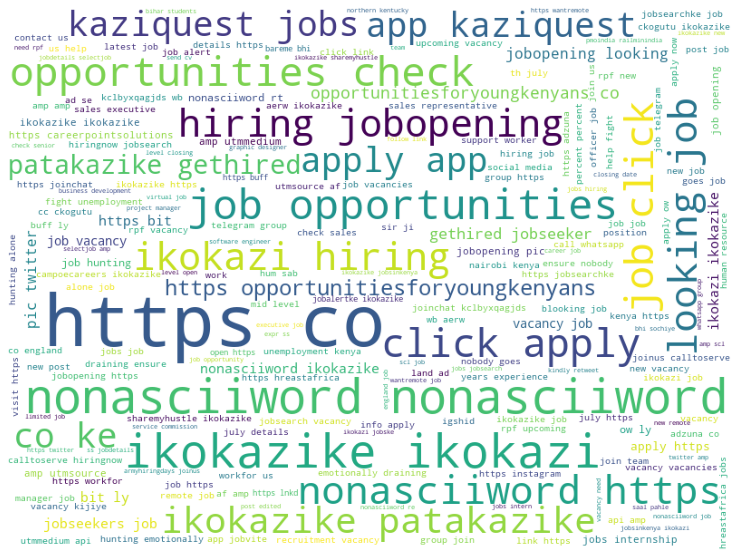

In [51]:
# display the word cloud.
#
cloud(' '.join(twitter_df['clean_tweet']))

In [52]:
a = 0 
for i in range(a,a+10):
    print(twitter_df.clean_tweet[i])
    print()

bladies         ikokazike   ikokazi today   i really admired this lady  will while she was busy at her daily hustle   https      t  co  dnd 2 lfikc 1 

b  ikokazike   ikokazi looking for a audit trainee living around mlolongo  kitengela or athi river area   dm for more info

b  moneychapke are an online crowdfunding and fundraising platform    log on to https      t  co  n 6 kinjx 0 uu  for inquiries write to them on hi  moneychap  co  ke    kameneandjalas   ikojob   twendekazike   businesschatke   ikokazike   ikokazi https      t  co  i 8 zttx 18 ua

bwe are an online crowdfunding and fundraising platform that allows both entrepreneurs   creatives   individuals and organizations raise funds easily and securely for causes and businesses     log on to https      t  co  fwvnl 1 wgxa  for inquiries   hi  moneychap  co  ke   ikokazi   ikokazike https      t  co  bpauxown 9 g

bstriding into the weekend with a productive first week  our social media is all set   this is the mood today as we

In [53]:
twitter_df.head()

,Text,Source,clean_tweet
0,"b""Ladies!!! #IkoKaziKE #IkoKazi Today, I reall...",b'Mimimkenya7',bladies ikokazike ikokazi today i ...
1,b'#IkoKaziKe #IkoKazi Looking for a Audit Trai...,b'MtandaoPromoter',b ikokazike ikokazi looking for a audit tra...
2,b'@moneychapKE are an online crowdfunding and ...,b'KameneAndJalas',b moneychapke are an online crowdfunding and ...
3,b'We are an online crowdfunding and fundraisin...,b'moneychapKE',bwe are an online crowdfunding and fundraising...
4,b'Striding into the weekend with a productive ...,b'amunsoft',bstriding into the weekend with a productive f...


### Bag Of Words

**Step 1: Tokenize the Sentences**
>>
The first step in this regard is to convert the sentences in our corpus into tokens or individual words.

In [56]:
for r, map in re_map.items():
    tweeter_df['clean_text'] = [re.sub(r, map, e) for e in tweeter_df['clean_text']]

NameError: ignored

In [54]:
twitter_text = twitter_df['clean_tweet']
twitter_sentences = nltk.sent_tokenize(twitter_text)
twitter_words = nltk.word_tokenize(twitter_text)

TypeError: ignored

**Step 2: Create a Dictionary of Word Frequency**
>>
The next step is to create a dictionary that contains all the words in our corpus as keys and the frequency of the occurrence of the words as values. In other words, we need to create a histogram of the words in our corpus.

**Step 3: Creating the Bag of Words Model**
>>
To create the bag of words model, we need to create a matrix where the columns correspond to the most frequent words in our dictionary where rows correspond to the document or sentences.

## Stemming

>>
Stemming converts words to its stem.
>>
Porter-Stemmer identifies and removes the suffix or affix of a word. 
>>
The words given by the stemmer need not be meaningful few times, but it will be identified as the same for the model.

**Example:**
>>
a) Jumping and jumped basically indicate jump.
>>
b) playing and played indicate play

## Lemmatisation

>>
Lemmatisation is a way to reduce the word to root synonym of a word. Unlike Stemming, Lemmatisation makes sure that the reduced word is again a dictionary word (word present in the same language). WordNetLemmatizer can be used to lemmatize any word.

>>
Python library - textstat to calculate statistics from text to determine readability, complexity and grade level of any article. 
>>
The meaning of each statistical feature value can be found <a href="https://pypi.org/project/textstat/">here</a>.

In [53]:
reading_ease = []
for doc in twitter_df['Text']:
    reading_ease.append(textstat.flesch_reading_ease(doc))
    
smog = []
for doc in twitter_df['Text']:
    smog.append(textstat.smog_index(doc))
    
kincaid_grade = []
for doc in twitter_df['Text']:
    kincaid_grade.append(textstat.flesch_kincaid_grade(doc))
    
liau_index = []
for doc in twitter_df['Text']:
    liau_index.append(textstat.coleman_liau_index(doc))
    
readability_index = []
for doc in twitter_df['Text']:
    readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in twitter_df['Text']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
difficult_words = []
for doc in twitter_df['Text']:
    difficult_words.append(textstat.difficult_words(doc))

write_formula = []
for doc in twitter_df['Text']:
    write_formula.append(textstat.linsear_write_formula(doc))

gunning_fog = []
for doc in twitter_df['Text']:
    gunning_fog.append(textstat.gunning_fog(doc))

text_standard = []
for doc in twitter_df['Text']:
    text_standard.append(textstat.text_standard(doc))
    
twitter_df['flesch_reading_ease'] = reading_ease
twitter_df['smog_index'] = smog
twitter_df['flesch_kincaid_grade'] = kincaid_grade
twitter_df['automated_readability_index'] = readability_index
twitter_df['dale_chall_readability_score'] = readability_score
twitter_df['difficult_words'] = difficult_words
twitter_df['linsear_write_formula'] = write_formula
twitter_df['gunning_fog'] = gunning_fog
twitter_df['text_standard'] = text_standard

**Type-Token Ratio (TTR)**
>>
<a href="https://towardsdatascience.com/linguistic-complexity-measures-for-text-nlp-e4bf664bd660">Resource</a> - Basic: Measuring the Linguistic Complexity of Text

In [56]:
ttr = []
for doc in twitter_df['Text']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

twitter_df['ttr'] = ttr
twitter_df.head()

,Text,Source,clean_tweet,flesch_reading_ease,smog_index,flesch_kincaid_grade,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,text_standard,ttr
0,"b""Ladies!!! #IkoKaziKE #IkoKazi Today, I reall...",b'Mimimkenya7',b '' ladies ! ! ! # ikokazike # ikokazi today ...,52.19,0.0,10.7,17.6,7.90,4,11.50,7.60,7th and 8th grade,1.000000
1,b'#IkoKaziKe #IkoKazi Looking for a Audit Trai...,b'MtandaoPromoter',b ' # ikokazike # ikokazi looking for a audit ...,70.13,0.0,8.0,14.5,8.92,5,9.00,9.42,8th and 9th grade,0.950000
2,b'@moneychapKE are an online crowdfunding and ...,b'KameneAndJalas',b ' @ moneychapke are an online crowdfunding a...,-5.68,0.0,20.5,32.5,12.21,12,20.00,19.63,19th and 20th grade,0.833333
3,b'We are an online crowdfunding and fundraisin...,b'moneychapKE',b'we are an online crowdfunding and fundraisin...,-6.36,0.0,22.8,32.1,12.59,16,26.50,22.00,12th and 13th grade,0.822222
4,b'Striding into the weekend with a productive ...,b'amunsoft',b'striding into the weekend with a productive ...,54.22,0.0,9.9,13.5,7.27,6,10.75,9.15,9th and 10th grade,0.894737


* Number of power words in the text (https://buffer.com/library/words-and-phrases-that-convert-ultimate-list/).

* Number of casual words in the text (https://www.researchgate.net/figure/Ten-Most-Frequent-Causal-Words_fig8_309156646).

* Number of tentative words in the text (https://lo.unisa.edu.au/pluginfile.php/1687800/mod_resource/content/0/Tentative%20language_Sept%202017.pdf#:~:text=Examples%20of%20tentative%20phrases%2Fvocabulary%20include%3A&text=may%2Fmight%2Fcan%2Fcould,each%20sentence%20becomes%20more%20tentative)

* Number of emotion words in the text (https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

## TFIDF

**TF-IDF** stands for “Term Frequency — Inverse Document Frequency”.

>> 
TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)
>>
**Terminology**
>>
t — term (word)
>>
d — document (set of words)
>>
N — count of corpus
>>
corpus — the total document set

<img src="https://image.slidesharecdn.com/introductiontoapachelucenesolr-140412130758-phpapp02/95/introduction-to-apache-lucenesolr-6-638.jpg?cb=1397308140"></img>

#### **Term Frequency**
>>
This measures the frequency of a word in a document. This highly depends on the length of the document and the generality of word
>>
***tf(t,d) = count of t in d / number of words in d***

>>
***TF = (Frequency of the word in the sentence) / (Total number of words in the sentence)***

#### **Inverse Document Frequency(IDF)**

>>
It is computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.
>>
***df(t) = occurrence of t in documents***

Where df is the Document Frequency.
>>
***idf(t) = N/df***
>>
There are few other problems with the IDF, in case of a large corpus, the IDF value explodes. So to dampen the effect we take the log of IDF. 
>>
***idf(t) = log(N/(df + 1))***
>>
A logarithmic scale (or log scale) is a way of displaying numerical data over a very wide range of values in a compact way.

>>
***IDF = (Total number of sentences (documents))/(Number of sentences (documents) containing the word)***

#### **Term Frequency Inverse Document Frequency(TF-IDF)**

>>
Therefore:
>>
***tf-idf(t, d) = tf(t, d) * log(N/(df + 1))***


> **NOTE**
>>
One of the main problems associated with the bag of words model is that it assigns equal value to the words, irrespective of their importance. 
>>
The idea behind the TF-IDF approach is that the words that are more common in one sentence and less common in other sentences should be given high weights.

In [ ]:
corpus = twitter_df['clean_tweet']
wordfreq = {}
for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

>>
The next step is to find the IDF values for the most frequently occurring words in the corpus.

In [ ]:
word_idf_values = {}
for token in most_freq:
    doc_containing_word = 0
    for document in corpus:
        if token in nltk.word_tokenize(document):
            doc_containing_word += 1
    word_idf_values[token] = np.log(len(corpus)/(1 + doc_containing_word))

>>
In the script above, we create an empty dictionary word_idf_values. This dictionary will store most frequently occurring words as keys and their corresponding IDF values as dictionary values. 
>>
We iterate through the list of most frequently occurring words. During each iteration, we create a variable ***doc_containing_word*** which will store the number of documents in which the word appears.
>>
Next we iterate throught the sentences in the corpus and check if the word exists. If does, wwe increment the ***doc_containing_word*** variable.

> The next step is to create the TF dictionary for each word.

In [ ]:
word_tf_values = {}
for token in most_freq:
    sent_tf_vector = []
    for document in corpus:
        doc_freq = 0
        for word in nltk.word_tokenize(document):
            if token == word:
                  doc_freq += 1
        word_tf = doc_freq/len(nltk.word_tokenize(document))
        sent_tf_vector.append(word_tf)
    word_tf_values[token] = sent_tf_vector

>>
In the above scipt, we create a dictionary that contains the word as the key a lis of the total number of sentenses in our corpus.
>>
Each item in the list stores the TF value of the word for the corresponding sentence. In the script above word_tf_values is our dictionary. For each word, we create a list sent_tf_vector.

>>
Now we have IDF values of all the words, along with TF values of every word across the sentences. The next step is to simply multiply IDF values with TF values.

In [ ]:
tfidf_values = []
for token in word_tf_values.keys():
    tfidf_sentences = []
    for tf_sentence in word_tf_values[token]:
        tf_idf_score = tf_sentence * word_idf_values[token]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

>>
In the above script, we create a list called tfidf_values. We then iterated through all the keys in the word_tf_values dictionary. These keys are basically the most frequently occurring words.
>>
We need to convert the two-dimensional list to a numpy array.

In [ ]:
tf_idf_model = np.asarray(tfidf_values)

>>
We want rows to represent the TF-IDF vectors. We can do so by simply transposing our numpy array as follows:

In [ ]:
tf_idf_model = np.transpose(tf_idf_model)

### Building a classifier

In [ ]:
X_train = df.loc[:24999, 'review'].values
y_train = df.loc[:24999, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

In [ ]:
from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))